In [18]:
import random
import os
import json
import pandas as pd
import numpy as np
import torch
from transformers import RobertaConfig, RobertaTokenizerFast, RobertaForTokenClassification, RobertaModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# from transformers import RobertaTokenizer, RobertaModel

random.seed(42)
reshuffle_docs = False

percent_to_test = .1
percent_to_dev = .2
percent_to_train =  1 - percent_to_dev - percent_to_test

batch_size = 10 # documents
learning_rate = 2e-4
n_epochs = 10

model_name = 'allenai/biomed_roberta_base'
dropout = .03

# annot_types = ['Quantity', 'MeasuredEntity', 'MeasuredProperty', 'Qualifier']

dummy_run = True

small_size = .2 # multiplier for making small datasets

In [2]:
currentdir = os.getcwd() # ~/MeasEval/baselines

combopath_txt = os.path.join(currentdir, "../data/raw/combo/text/")
combopath_annot = os.path.join(currentdir, "../data/raw/combo/tsv/")

interimpath = os.path.join(currentdir, "../data/interim/")



if reshuffle_docs == True:
    docIds = []
    combo_txt = {}
    for fn in os.listdir(combopath_txt):
        docIds.append(fn[:-4])
        path = combopath_txt+fn
        with open(path) as textfile:
                text = textfile.read()
                #[:-4] strips off the .txt to get the id
                combo_txt[fn[:-4]] = text

    combo_annot = pd.DataFrame()
    for fn in os.listdir(combopath_annot):
        path = combopath_annot+fn
        file = pd.read_csv(path,delimiter='\t',encoding='utf-8')
        combo_annot = pd.concat([combo_annot, file],ignore_index=True)

    random.shuffle(docIds)

    n_doc = len(docIds)
    split_train = int(np.round(n_doc * percent_to_train))
    split_dev = split_train + int(np.round(n_doc * percent_to_dev))

    docs_train = docIds[:split_train]
    docs_dev = docIds[split_train:split_dev]
    docs_test = docIds[split_dev:]

    train_annot = combo_annot.loc[combo_annot['docId'].isin(docs_train)]
    dev_annot = combo_annot.loc[combo_annot['docId'].isin(docs_dev)]
    test_annot = combo_annot.loc[combo_annot['docId'].isin(docs_test)]

    # save data
    train_annot.to_csv(interimpath+'train_annot.csv')
    dev_annot.to_csv(interimpath+'dev_annot.csv')
    test_annot.to_csv(interimpath+'test_annot.csv')

    train_txt = {d: combo_txt[d] for d in docs_train}
    dev_txt = {d: combo_txt[d] for d in docs_dev}
    test_txt = {d: combo_txt[d] for d in docs_test}
    
    with open(interimpath+'train_txt.json','w') as f:
        json.dump(train_txt, f)
    with open(interimpath+'dev_txt.json','w') as f:
        json.dump(dev_txt, f)
    with open(interimpath+'test_txt.json','w') as f:
        json.dump(test_txt, f)

else:
    train_annot = pd.read_csv(interimpath+'train_annot.csv')
    dev_annot = pd.read_csv(interimpath+'dev_annot.csv')
    test_annot = pd.read_csv(interimpath+'test_annot.csv')

    with open(interimpath+'train_txt.json','r') as f:
        train_txt = json.load(f)
    with open(interimpath+'dev_txt.json','r') as f:
        dev_txt = json.load(f)
    with open(interimpath+'test_txt.json','r') as f:
        test_txt = json.load(f)

train_docIds = list(set(train_annot['docId']))
dev_docIds = list(set(dev_annot['docId']))
test_docIds = list(set(test_annot['docId']))

In [3]:
########## Tokenizer & Model ###########

# config = RobertaConfig.from_pretrained(model_name, problem_type='multi_label_classification', num_labels=2, label2id={'QUANT':1,'NOT QUANT':0})



tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="pt", padding='max_length')


########## Optimizer & Loss ###########

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [4]:
def tokenize_and_align_labels(docs_or_sents, txt, annotation, type=type, tokenizer=tokenizer):
    
    toks_with_labels = []

    for doc in docs_or_sents:
        # print(doc)

        encoded_txt = tokenizer(txt[doc], padding='max_length', max_length=512, truncation=True)
        # print(encoded_txt)

        encoded_tokens = encoded_txt['input_ids']
        # print(encoded_tokens)

        doc_annot = annotation.loc[annotation['docId'] == doc]
        # print(doc_annot)

        annot_spans = np.array(doc_annot[['startOffset','endOffset']])
        # print(f'annot_spans={annot_spans}')

        label_ids = np.full(len(encoded_tokens),0)
        special_ids = tokenizer.all_special_ids
        # print(label_ids.shape)

        for token_idx, token in enumerate(encoded_tokens):
            # decoded_token = tokenizer.decode(token)
            # print(f"token index: {token_idx}")
            # print(f"decoded token: {decoded_token}")

            if token in special_ids:
                label_ids[token_idx] = 0
                # print('special token')

            else:
                token_start_char = encoded_txt.token_to_chars(token_idx).start
                token_end_char = encoded_txt.token_to_chars(token_idx).end
                # print(f"token span: {[token_start_char,token_end_char]}")
                for start, end in annot_spans:
                    if start <= token_start_char <= end:
                        label_ids[token_idx] = 1
                        # print(f'{type} entity found spanning {[start,end]}')
                        break
                    else:
                        label_ids[token_idx] = 0
                        # print("no entity found")
        
        encoded_txt['doc_or_sent_id'] = doc
        encoded_txt['labels'] = list(label_ids)
        toks_with_labels.append(encoded_txt)
    # return toks_with_labels
    return pd.DataFrame.from_dict(toks_with_labels)

In [5]:
################# TOKENIZE #################
small_train_docIds = random.sample(train_docIds, int(len(train_docIds)*small_size))

quant_small_train_dataset = tokenize_and_align_labels(
    docs_or_sents=small_train_docIds,
    txt=train_txt,
    annotation=train_annot,
    type='Quantity',
    tokenizer=tokenizer)


small_dev_docIds = random.sample(dev_docIds, int(len(dev_docIds)*small_size))

quant_small_dev_dataset = tokenize_and_align_labels(
    docs_or_sents=small_dev_docIds,
    txt=dev_txt,
    annotation=dev_annot,
    type='Quantity',
    tokenizer=tokenizer)

test_docIds = test_docIds

quant_test_dataset = tokenize_and_align_labels(
    docs_or_sents=test_docIds,
    txt=test_txt,
    annotation=test_annot,
    type='Quantity',
    tokenizer=tokenizer)


In [6]:
def batchify(tokenized_dataset, batch_size):
    num_examples = int(tokenized_dataset.shape[0] / batch_size)
    batch_sizes = [batch_size for x in range(num_examples)]
    last_batch_size = tokenized_dataset.shape[0] % batch_size
    if last_batch_size:
        batch_sizes.append(last_batch_size)
    print(batch_sizes)

    batched_dataset = []

    for idx, size in enumerate(batch_sizes):
        start = sum(batch_sizes[:idx])
        end = sum(batch_sizes[:idx]) + size - 1
        # print(start,end,idx)
        input_ids = torch.LongTensor(tokenized_dataset['input_ids'].loc[start:end].tolist())
        attention_mask = torch.LongTensor(tokenized_dataset['attention_mask'].loc[start:end].tolist())
        labels = torch.LongTensor(tokenized_dataset['labels'].loc[start:end].tolist())
        print(labels.shape)
        doc_or_sent_id = list(tokenized_dataset['doc_or_sent_id'].loc[start:end])
        
        batch = {
            'input_ids':input_ids,
            'attention_mask':attention_mask,
            'labels':labels,
            'doc_or_sent_id':doc_or_sent_id
        }
        
        batched_dataset.append(batch)

    return batched_dataset

# batched_dev_ds = batchify(quant_small_dev_dataset, batch_size=batch_size)
# print(batched_dev_ds[0]['labels'][7])

In [7]:
################# batchify ####################
batched_quant_small_train_ds = batchify(quant_small_train_dataset, batch_size=batch_size)
batched_quant_small_dev_ds = batchify(quant_small_dev_dataset, batch_size=batch_size)
batched_quant_small_test_ds = batchify(quant_test_dataset, batch_size=batch_size)

print()


[10, 10, 10, 10, 10, 10]
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 512])
[10, 7]
torch.Size([10, 512])
torch.Size([7, 512])
[10, 10, 10, 10, 2]
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([2, 512])



In [8]:
config = RobertaConfig.from_pretrained(model_name)
model = RobertaForTokenClassification._from_config(config)
criterion = torch.nn.CrossEntropyLoss()

from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=learning_rate)

from transformers import get_scheduler

num_epochs = n_epochs
num_training_steps = num_epochs * len(batched_quant_small_train_ds)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

import torchmetrics

f1 = torchmetrics.F1Score()
acc = torchmetrics.Accuracy(mdmc_average='samplewise')

from tqdm.auto import tqdm


In [9]:

progress_bar = tqdm(range(num_training_steps))

logger = {
    'epochs':[],
    'batches':[],
    'train_losses':[],
    'eval_losses':[]
}

def train_once(ds=batched_quant_small_train_ds):
    model.train()
    for idx, batch in enumerate(batched_quant_small_train_ds):
        logger['batches'].append(idx+1)
        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        outputs = model(input_ids, attention_mask)
        logits = outputs.logits
        
        train_loss = criterion(logits.permute(0,2,1), labels)
        logger['train_losses'].append(train_loss.item())
        
        train_loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)


def eval_once(ds=batched_quant_small_dev_ds):
    model.eval()
    for idx, batch in enumerate(ds):
        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']

        output = model(input_ids, attention_mask, labels=labels)
        logits = output.logits.permute(0,2,1)
        
        # logger['eval_losses'].append(output.loss).item()
        
        predictions = torch.argmax(logits, dim=1)
        # print(predictions)
        batch['predictions'] = predictions
        print(acc(labels,predictions))

        # classification_report(labels[0], predictions[0])

for epoch in range(num_epochs):
    logger['epochs'].append(epoch+1)
    
    train_once()
    eval_once()

    print(logger)

  0%|          | 0/60 [00:00<?, ?it/s]

tensor(0.9563)
tensor(0.9428)
{'epochs': [1], 'batches': [1, 2, 3, 4, 5, 6], 'train_losses': [1.5162665843963623, 0.564725399017334, 0.759817898273468, 11.09130859375, 3.1185202598571777, 0.4187241196632385], 'eval_losses': []}
tensor(0.9563)
tensor(0.9428)
{'epochs': [1, 2], 'batches': [1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6], 'train_losses': [1.5162665843963623, 0.564725399017334, 0.759817898273468, 11.09130859375, 3.1185202598571777, 0.4187241196632385, 0.388182133436203, 0.38244616985321045, 1.0842511653900146, 0.7320479154586792, 0.6392818689346313, 0.5434420108795166], 'eval_losses': []}
tensor(0.9563)
tensor(0.9428)
{'epochs': [1, 2, 3], 'batches': [1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6], 'train_losses': [1.5162665843963623, 0.564725399017334, 0.759817898273468, 11.09130859375, 3.1185202598571777, 0.4187241196632385, 0.388182133436203, 0.38244616985321045, 1.0842511653900146, 0.7320479154586792, 0.6392818689346313, 0.5434420108795166, 0.2714674174785614, 0.20074506103

In [10]:
batched_quant_small_dev_ds[0]

{'input_ids': tensor([[    0,  1121,   937,  ...,     1,     1,     1],
         [    0, 27526,  9021,  ...,     1,     1,     1],
         [    0,   133,   511,  ...,     1,     1,     1],
         ...,
         [    0, 30383,    58,  ...,     1,     1,     1],
         [    0, 20823,  3899,  ...,     1,     1,     1],
         [    0, 46444,     7,  ...,     1,     1,     1]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'doc_or_sent_id': ['S0921818113002245-1752',
  'S0378383912000130-1048',
  'S0038071713001971-1427',
  'S1359645413009816-2227',
  'S095

In [21]:
batch = batched_quant_small_dev_ds[0]

labels = batch['labels']
input_ids = batch['input_ids']
attention_mask = batch['attention_mask']

output = model(input_ids, attention_mask, labels=labels)
logits = output.logits.permute(0,2,1)

# logger['eval_losses'].append(output.loss).item()

predictions = torch.argmax(logits, dim=1)
# print(predictions)
batch['predictions'] = predictions
print(acc(labels,predictions))
print(labels)
confusion_matrix(labels[0],predictions[0])

tensor(0.9563)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


array([[492,   0],
       [ 20,   0]])

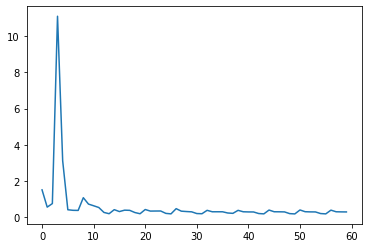

In [22]:
# np.array(logger['train_losses'])

import matplotlib.pyplot as plt
y = np.array(logger['train_losses'])
x = np.array(range(len(logger['batches'])))
plt.plot(x,y)
plt.show()